# Using Bike Collision and Other Data to Predict Car Accidents #
## Data Collection and Cleaning ##

Harvard University has collected a number of Boston Area data sets ffor their Boston Area Research Intitiative. The key data for this project about predicting bike accidents was derived from Boston Police Department incident narrative reports, as organized and compiled by Dahianna Lobez and partners ad BPD, BARI, and the Boston Cyclists Union.

This data is for collisions that occured between 2009 and 2012.

### Bike Collision Data ###

In [4]:
import pandas as pd
import geopandas as gpd
import math
from shapely.geometry import Point, LineString, Polygon
from pyproj import Proj, transform
from matplotlib import pyplot as plt

In [5]:
bike_df_orig = pd.read_excel('data/Final_Bike_Collision_Database.xlsx')
bike_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 54 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ID          1808 non-null   object        
 1   YEAR        1797 non-null   float64       
 2   DATE        1797 non-null   datetime64[ns]
 3   DAY_WEEK    1795 non-null   object        
 4   TIME        1797 non-null   object        
 5   TYPE        1795 non-null   object        
 6   SOURCE      1699 non-null   object        
 7   XFINAL      1731 non-null   float64       
 8   Xkm         1730 non-null   float64       
 9   YFINAL      1731 non-null   float64       
 10  Ykm         1731 non-null   float64       
 11  Address     1730 non-null   object        
 12  Main        1731 non-null   float64       
 13  RoadType    1726 non-null   object        
 14  ISINTERSEC  1807 non-null   float64       
 15  TRACT       1731 non-null   float64       
 16  CouncilDIS  1731 non-nul

**Xkm** and **Ykm** encode the location of the accident. For this project I'm not interested in accidents that don't have a location, so I'll drop the rows with missing locations.

I also want to make sure there aren't outliers in the location data. The Xkm and Ykm values are meter coordinates in a Massachusetts-specific geographic system. I'll convert them to latitude and logitude and make sure that they don't exceed the map of Boston.

In [6]:
bike_df = pd.DataFrame(bike_df_orig[(bike_df_orig.Xkm > 0) & (bike_df_orig.Ykm > 0)])

# convert the bike data locations into latitude and longitudes and find the geographic extent
inProj = Proj('epsg:26986')
outProj = Proj('epsg:4326')
xmax,ymax = bike_df['Xkm'].max(),bike_df['Ykm'].max()
xmax2,ymax2 = transform(inProj,outProj,xmax,ymax)
print ('Upper Right: ')
print (xmax2,ymax2)

xmin,ymin = bike_df['Xkm'].min(),bike_df['Ykm'].min()
xmin2,ymin2 = transform(inProj,outProj,xmin,ymin)

print('Bottom Right:')
print(xmin2, ymax2)

print('Top Right: ')
print(xmax2, ymin2)

print ('Bottom Left: ')
print (xmin2,ymin2)

Upper Right: 
42.385920811282396 -71.00003640589748
Bottom Right:
42.23530626734878 -71.00003640589748
Top Right: 
42.385920811282396 -71.17443656586595
Bottom Left: 
42.23530626734878 -71.17443656586595


The other columns we may be interested in are RoadType and ISINTERSECT but we can find that data from our other data sets as well, so I'll consider data cleaning on Bike Collision data done at this point.

In [4]:
#output saved bike info for later use
bike_df.to_csv(r'data/cleaned_data/bike_accident_clean.csv')

### Car Accident Data ###
Car accident crash data is from kaggle. https://www.kaggle.com/sobhanmoosavi/us-accidents and shows car accidents in 2019.

In [5]:
car_df = pd.read_csv('data/US_Accidents_Dec19.csv')
len(car_df)

2974335

This is a massive file with nearly 3 million rows and that covers the whole of the US, so the first task is to limit it to the same area as the bike accidents above.

In [6]:
# To capture accidents that may have happened at the edges of the bike collision area
# keep accidents that either start or end within the area
car_df = car_df[((car_df['Start_Lat'] <= xmax2) & (car_df['Start_Lat'] >= xmin2) & 
                 (car_df['Start_Lng'] <= ymax2) & (car_df['Start_Lng'] >= ymin2) |
                (car_df['End_Lat'] <= xmax2) & (car_df['End_Lat'] >= xmin2) & 
                 (car_df['End_Lng'] <= ymax2) & (car_df['End_Lng'] >= ymin2))]

# Re-index because we've removed a lot of values
car_df = car_df.reset_index()

len(car_df)

6343

No other cleaning is necessary on this data, since the only thing I'm interested in is accident locations.

The Mass DOT geospatial system is convenient for this project, so I'll add new columns to contain that data.

In [31]:
inProj = Proj('epsg:4326')
outProj = Proj('epsg:26986')

#loop through car datafram to create a list of lists containing the new coordinates
points_list = []
for index, row in car_df.iterrows():
    points_row = []
    start_points = list(transform(inProj,outProj,row['Start_Lat'],row['Start_Lng']))
    points_row.append(start_points[0])
    points_row.append(start_points[1])
    end_points = list(transform(inProj,outProj,row['End_Lat'],row['End_Lng']))
    points_row.append(end_points[0])
    points_row.append(end_points[1])
    points_list.append(points_row)

converted_car_df = pd.DataFrame(points_list, columns=['Start_Xkm', 'Start_Ykm', 'End_Xkm', 'End_Ykm'])
len(converted_car_df)
#car_df[['Start_Xkm', 'Start_Ykm']] = transform(inProj,outProj,car_df['Start_Lat'],car_df['Start_Lng'])



6343

That was an extremely time-consuming conversion. Here I've outputted the converted data for posterity so I don't have to do that again. Then I'm adding these as columns to the car data, and outputting that as well.

In [40]:
#output convered car accident locations for later use
converted_car_df.to_csv(r'data/cleaned_data/converted_car_locs.csv')



In [35]:
car_df = pd.concat([car_df, converted_car_df], axis=1)
car_df.head()

,index,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Start_Xkm,Start_Ykm,End_Xkm,End_Ykm
0,194279,A-194281,MapQuest,201.0,2,2016-11-30 17:18:00,2016-11-30 18:35:00,42.251457,-71.002701,NaN,...,False,False,Night,Night,Night,Day,241037.320696,889118.737133,NaN,NaN
1,194286,A-194288,MapQuest,201.0,3,2016-11-30 17:57:43,2016-11-30 19:12:25,42.298656,-71.047501,NaN,...,False,False,Night,Night,Night,Night,237312.630240,894340.699035,NaN,NaN
2,194332,A-194334,MapQuest,201.0,2,2016-12-01 05:13:34,2016-12-01 05:43:02,42.335854,-71.107498,NaN,...,True,False,Night,Night,Night,Night,232346.360202,898447.945054,NaN,NaN
3,194338,A-194340,MapQuest,201.0,3,2016-12-01 06:15:12,2016-12-01 06:44:56,42.330719,-71.060905,NaN,...,False,False,Night,Night,Day,Day,236189.025531,897896.294689,NaN,NaN
4,194397,A-194399,MapQuest,201.0,2,2016-12-01 07:59:19,2016-12-01 08:28:54,42.361366,-71.072342,NaN,...,False,False,Day,Day,Day,Day,235229.359109,901295.621937,NaN,NaN


In [39]:
car_df.to_csv(r'data/cleaned_data/car_accidents_cleaned.csv')

### Road Data ###
Mass DOT has a database of road data in a .gpd file (https://geo-massdot.opendata.arcgis.com/datasets/road-inventory-2018). This has geometric data about the roads which will be very helpful, and a lot of qualitative road data with a code book [here](RI-DataDictionary.pdf).

I'm going to read in the full roads database, trim to only Boston data, and see if I can find the missing values.

In [38]:
roads_2018 = gpd.read_file('data\RoadInv2018.gdb', layer=0)
roads_2018.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 573677 entries, 0 to 573676
Data columns (total 70 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   Route_ID         573677 non-null  object  
 1   From_Measure     573677 non-null  float64 
 2   To_Measure       573677 non-null  float64 
 3   Route_System     573676 non-null  object  
 4   Route_Number     573676 non-null  object  
 5   Route_Direction  558198 non-null  object  
 6   Rd_Seg_ID        217904 non-null  float64 
 7   Facility         465908 non-null  float64 
 8   Mile_Count       463858 non-null  float64 
 9   F_Class          563956 non-null  float64 
 10  Urban_Area       563682 non-null  object  
 11  Urban_Type       563682 non-null  float64 
 12  F_F_Class        563956 non-null  float64 
 13  Jurisdictn       562317 non-null  object  
 14  NHS              561914 non-null  float64 
 15  Fd_Aid_Rd        216217 non-null  float64 
 16  Control     

To limit roads_2018 to only boston roads, I'll use geopandas functions to remove roads that aren't in the bike accident extent.

In [39]:
# Create shape that contains all bike accidents using mins and maxes from above
bike_shape = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])

In [40]:
# Rename geometry column so I don't lose it during the overlay
roads_2018 = roads_2018.rename(columns={'geometry': 'road_shape'})

In [42]:
# In order to perform an interection, I need a column in roads_2018 that contains polygons
roads_2018 = roads_2018.set_geometry('road_shape')
roads_2018['buffer'] = roads_2018['road_shape'].buffer(50)
roads_2018 = roads_2018.set_geometry('buffer')

In [44]:
# Create GeoDataFrame out of bike shape to enable overlay
bike_df = gpd.GeoDataFrame({ 'shape': [bike_shape]})
bike_df = bike_df.set_geometry('shape')

In [45]:
rd_gdf = gpd.overlay(bike_df, roads_2018, how='intersection')

In [46]:
len(rd_gdf)

34049

In [47]:
rd_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34049 entries, 0 to 34048
Data columns (total 71 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Route_ID         34049 non-null  object  
 1   From_Measure     34049 non-null  float64 
 2   To_Measure       34049 non-null  float64 
 3   Route_System     34049 non-null  object  
 4   Route_Number     34049 non-null  object  
 5   Route_Direction  32659 non-null  object  
 6   Rd_Seg_ID        13195 non-null  float64 
 7   Facility         29161 non-null  float64 
 8   Mile_Count       29154 non-null  float64 
 9   F_Class          33369 non-null  float64 
 10  Urban_Area       33368 non-null  object  
 11  Urban_Type       33368 non-null  float64 
 12  F_F_Class        33369 non-null  float64 
 13  Jurisdictn       33152 non-null  object  
 14  NHS              33324 non-null  float64 
 15  Fd_Aid_Rd        13122 non-null  float64 
 16  Control          33169 non-null 

Spot checking some values for outliers.


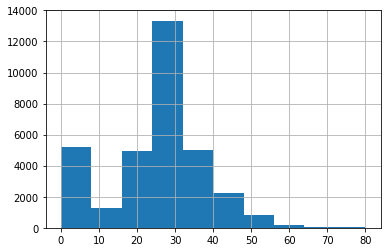

In [35]:
rd_gdf['Surface_Wd'].hist()

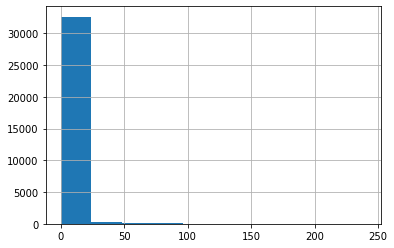

In [36]:
rd_gdf['Med_Width'].hist()

250m width for the road median seems like it might be an outlier, but it's not impossible on a highway. I may want to remove highways, but we'll see, and they don't make up many of the roads in Boston anyway.

In [48]:
# output to file
rd_gdf.to_csv(r'data/cleaned_data/boston_roads_gpd.csv')